In [87]:
import sys
from pathlib import Path

# Lấy thư mục làm việc hiện tại
current_dir = Path.cwd()

# Đi lên một cấp
parent_dir = current_dir.parent

sys.path.insert(0, str(parent_dir))


In [ ]:
import base64
from typing import Annotated, List, Union

# import magic
import requests
from IPython.display import Image, display
from langchain_community.tools import (
    ArxivQueryRun,
    DuckDuckGoSearchResults,
    WikipediaQueryRun,
)
from langchain_community.utilities import (
    ArxivAPIWrapper,
    DuckDuckGoSearchAPIWrapper,
    WikipediaAPIWrapper,
)
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, create_react_agent, tools_condition
from pydantic import BaseModel, Field
from typing_extensions import TypedDict


from typing import Optional
from langchain_core.tools import BaseTool
from langchain_core.tools import tool
from langchain_core.tools.base import ArgsSchema
from pydantic import BaseModel, Field
from langgraph.checkpoint.memory import MemorySaver
import operator
# from ultralytics import YOLO

In [89]:
llm: ChatOpenAI = ChatOpenAI(
    base_url="http://127.0.0.1:1234/v1",
    temperature=0,
    api_key="not-needed"
)

## Tools

### KBs tools

In [15]:
arxiv_wrapper = ArxivAPIWrapper(
    top_k_results=2, 
    arxiv_search=None,
    arxiv_exceptions=None
)
arxiv = ArxivQueryRun(api_wrapper=arxiv_wrapper)
arxiv_result = arxiv.run("Rotary Positional Encoding")
print(arxiv_result)
print("------------------")
wikipedia_wrapper = WikipediaAPIWrapper(top_k_results=2, wiki_client=None)
wikipedia = WikipediaQueryRun(
    api_wrapper=wikipedia_wrapper,
    description="Search for information on a given topic using Wikipedia"
)
result_wikipedia = wikipedia.invoke("machine learning")
print(result_wikipedia)

Published: 2025-03-03
Title: Rotary Outliers and Rotary Offset Features in Large Language Models
Authors: André Jonasson
Summary: Transformer-based Large Language Models (LLMs) rely on positional encodings
to provide sequence position information to their attention mechanism. Rotary
Positional Encodings (RoPE), which encode relative position by rotating queries
and keys, have become widely used in modern LLMs. We study the features and
patterns that emerge in queries and keys when using rotary embeddings. Our
analysis reveals consistent patterns within the same model across layers and
attention heads and across different models and architectures. We present and
apply analysis techniques and show how the queries and keys use RoPE to
construct various attention patterns, including attention sinks. We find and
analyze outliers across models in queries and keys and find that they are
likely to be found in rotary features with partial cycles. We derive bounds
that tell us what rotary freque

### VQA tool

In [91]:
from langchain_core.tools import tool

@tool
def vqa_tool(image_url: str, question: str) -> str:
    """return the candidate answer with probability of the question"""
    return candidate_answers(image_url, question)


In [92]:
tools = [arxiv, wikipedia, duck_search, vqa_tool]
tools_by_name = {tool.name: tool for tool in tools}

tools_by_name

{'arxiv': ArxivQueryRun(description='Search for papers on a given topic using Arxiv', api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=2, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=1000)),
 'wikipedia': WikipediaQueryRun(description='Search for information on a given topic using Wikipedia', api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'd:\\Asus\\App\\miniconda\\workspace\\envs\\MAknowledge\\lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000)),
 'duckduckgo_results_json': DuckDuckGoSearchResults(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='auto', source='text'), output_format='list'),
 'vqa_t

## Generate Agent

### State

In [93]:
class Analyst(BaseModel):
    name: str = Field(
        description="Name of the analyst."
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    tools: List[str]

    system_prompt: str = Field(
        description="System prompt for the analyst.",
    )
    
    @property
    def affiliation(self) -> str:
        return f"{self.name} Agent for VQA"
    
    @property
    def persona(self) -> str:
        return f"Name: {self.affiliation}\nTools: {self.tools}\nDescription: {self.description}"

In [94]:
class GenerateAnalystsState(TypedDict):
    question: str
    image: str
    caption: str
    analysts: List[Analyst] 

### Node

In [95]:
def create_analysts(state: GenerateAnalystsState):
    analyst_specs = {
        "junior": {
            "name": "Junior",
            "description": "A junior analyst who uses only the vanilla VQA model to generate candidate answers.",
            "tools": ["vqa_tool"],
            "system_prompt": """You are junior analyst. Please provide the actions for the given task.
                                ===
                                The actions should be in [Action_1].
                                Action_1 (vqa_tool) is that you need to refer candidate answers to answer questions.
                                ===
                                task: {task}
                                the response should be like this: Action_1
                            """
        },
        "senior": {
            "name": "Senior",
            "description": "A senior analyst who uses both the VQA model and KBs retrieval to enhance answers.",
            "tools": ["vqa_tool", "arxiv", "wikipedia", "duckduckgo_results_json"],
            "system_prompt": """
                You are a senior analyst. For every incoming question, you **must**:

                1. **Action_1 (vqa_tool):** Perform visual question answering on any provided image(s).  
                2. **Action_2 (arxiv, wikipedia, duckduckgo_results_json):** Retrieve supporting background knowledge.

                **Procedure**  
                - Always start with Action_1.  
                - Then immediately follow with Action_2.
            """
        },
        # "manager": {
        #     "name": "Manager",
        #     "description": "A manager analyst with access to all tools including LLM-based knowledge generation.",
        #     "tools": ["arxiv", "wikipedia", "duckduckgo_results_json"]
        # }
    }

    # Tạo list các Analyst object
    analysts = [Analyst(**spec) for spec in analyst_specs.values()]

    return {"analysts": analysts}

def init_caption(state: GenerateAnalystsState):
    
    return {"caption": state["caption"]}

### Build graph

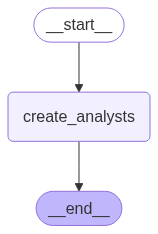

In [96]:
# Add nodes and edges
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", END)

# Compile
memory = MemorySaver()
gen_analysis_graph = builder.compile(checkpointer=memory)

# View
display(Image(gen_analysis_graph.get_graph(xray=1).draw_mermaid_png()))

In [97]:
thread = {"configurable": {"thread_id": "1"}}
analysts = gen_analysis_graph.invoke({"question": "What color is the dog's fur?"}, thread)

In [98]:
senior_des = analysts["analysts"][1]
senior_des

Analyst(name='Senior', description='A senior analyst who uses both the VQA model and KBs retrieval to enhance answers.', tools=['vqa_tool', 'arxiv', 'wikipedia', 'duckduckgo_results_json'], system_prompt='You are a senior analyst tasked with answering complex questions by combining visual analysis and knowledge retrieval.\n                        ===\n                        The actions should be in [Action_1, Action_2, Action_3].\n                        Action_1 (vqa_tool) is that you need to refer candidate answers to answer questions.\n                        Action_2 (arxiv, wikipedia) is that you need retrieve knowledge from KBs to answer questions.\n                        ===\n                        task: {task}\n                        the response should be like this: Action_1, Action_2\n                    ')

## Visual-research Agent

### State

In [99]:
class ViReAgentState(MessagesState):
    question: str
    image: str
    analysts: List[Analyst]
    results: Annotated[List[str], operator.add] = []


class ViReJuniorState(MessagesState):
    question: str
    image: str
    analyst: Analyst
    number_of_steps: int = 0
    answer_candidate: str= ""

class ViReSeniorState(MessagesState):
    question: str
    image: str
    analyst: Analyst
    number_of_steps: int = 0
    answer_candidate: str = ""
    KBs_Knowledge: Annotated[List[str], operator.add] = []

class ViReManagerState(MessagesState):
    question: str
    image: str
    analyst: Analyst
    number_of_steps: int = 0
    answer_candidate: str = ""
    KBs_Knowledge: Annotated[List[str], operator.add] = []
    LLM_Knowledge: str = ""


### Node

In [100]:
from langchain_core.runnables import RunnableConfig
import json
from langchain_core.messages import ToolMessage


def tool_node(state: Union[ViReJuniorState, ViReSeniorState, ViReManagerState]):
    outputs = []
    tool_calls = state["messages"][-1].tool_calls
    print(f"Processing {len(tool_calls)} tool calls")
    
    updates = {"messages": outputs}

    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        try:
            if tool_name == "vqa_tool":
                print(f"Processing vqa_tool calls")
                args = tool_call["args"]
                if not args.get("image_url"):
                    args["image_url"] = state.get("image")
                result = vqa_tool(args)
                print(f"Result: {result}")
                updates["answer_candidate"] = result
            elif tool_name in ["arxiv", "wikipedia", "duckduckgo_results_json"]:
                print(f"Processing {tool_name} calls")
                result = tools_by_name[tool_name].invoke(tool_call["args"])
                print(f"Result: {result}")
                if "KBs_Knowledge" not in updates:
                    updates["KBs_Knowledge"] = []
                if isinstance(result, str):
                    updates["KBs_Knowledge"].append(result)
                elif isinstance(result, list):
                    updates["KBs_Knowledge"].extend(result)
            else:
                result = f"Unknown tool: {tool_name}"

            outputs.append(
                ToolMessage(
                    content=json.dumps(result),
                    name=tool_name,
                    tool_call_id=tool_call["id"],
                )
            )
        except Exception as e:
            print(f"Error processing tool {tool_name}: {e}")
            outputs.append(
                ToolMessage(
                    content=f"Error: {str(e)}",
                    name=tool_name,
                    tool_call_id=tool_call["id"],
                )
            )
    return updates


# Define the node that calls the model
def call_vire_agent(
    state: Union[ViReJuniorState, ViReSeniorState, ViReManagerState],
    config: RunnableConfig,
):
    tools = state["analyst"].tools
    tools = [tools_by_name[tool] for tool in tools]
    llm: ChatOpenAI = ChatOpenAI(
        base_url="http://127.0.0.1:1234/v1",
        temperature=0,
        api_key="not-needed"
    ).bind_tools(tools)
    system_prompt = SystemMessage(
        content=state["analyst"].system_prompt
    )
    question_prompt = HumanMessage(content=f"question: {state['question']}")
    history = state.get("messages", [])
    sequence = [system_prompt, question_prompt] + history

    response = llm.invoke(sequence, config)

    
    updates = dict(state)  # Copy toàn bộ state hiện tại
    updates["messages"] = state["messages"] + [response]  # Append response mới
    
    return updates


def final_reasoning_node(state: Union[ViReJuniorState, ViReSeniorState, ViReManagerState]):
    """Node cuối cùng để tổng hợp kết quả và đưa ra câu trả lời final"""
    
    # Tạo context từ các thông tin đã thu thập
    context_parts = []
    
    print("state:", state)
    # Thêm answer_candidate nếu có (từ VQA)
    if state.get("answer_candidate"):
        context_parts.append(f"Visual Analysis Result: {state['answer_candidate']}")
    
    # Thêm KBs_Knowledge nếu có
    if state.get("KBs_Knowledge"):
        kb_info = "\n".join(state["KBs_Knowledge"])
        context_parts.append(f"Knowledge Base Information:\n{kb_info}")
    
    # Thêm LLM_Knowledge nếu có
    if state.get("LLM_Knowledge"):
        context_parts.append(f"LLM Generated Knowledge: {state['LLM_Knowledge']}")
    
    # Tạo final reasoning prompt
    context = "\n\n".join(context_parts)
    
    final_system_prompt = f"""
    You are a {state['analyst'].name} analyst. Based on the information gathered from various tools, 
    provide a comprehensive and final answer to the user's question.
    
    Available Information:
    {context}
    
    Original Question: {state['question']}
    
    Instructions:
    1. Analyze all available information
    2. Synthesize the findings
    3. Provide a clear, concise final answer
    4. Explain your reasoning briefly
    """
    
    llm = ChatOpenAI(
        base_url="http://127.0.0.1:1234/v1",
        temperature=0.1,  
        api_key="not-needed"
    )
    
    system_msg = SystemMessage(content=final_system_prompt)
    human_msg = HumanMessage(content="Please provide your final analysis and answer.")
    
    final_response = llm.invoke([system_msg, human_msg])
    print("answer_candidate:", state.get("answer_candidate", None))
    

    return {
        "messages": [final_response],
        "results": [final_response.content],
        "number_of_steps": state.get("number_of_steps", 0) + 1
    }



def should_continue(state: Union[ViReJuniorState, ViReSeniorState, ViReManagerState]):
    messages = state["messages"]
    last_message = messages[-1]
    
    # Nếu không có tool calls, chuyển sang final reasoning
    if not last_message.tool_calls:
        return "final_reasoning"
    # Nếu có tool calls, tiếp tục với tools
    else:
        return "continue"

### Graph

In [101]:
from langgraph.graph import StateGraph, END

def create_junior_subgraph():
    """Tạo subgraph cho Junior Analyst"""
    workflow = StateGraph(ViReJuniorState)
    
    workflow.add_node("agent", call_vire_agent)
    workflow.add_node("tools", tool_node)
    workflow.add_node("final_reasoning", final_reasoning_node)
    
    workflow.set_entry_point("agent")
    workflow.add_conditional_edges("agent", should_continue, {
        "continue": "tools",
        "final_reasoning": "final_reasoning"
    })
    workflow.add_edge("tools", "agent")
    workflow.add_edge("final_reasoning", END)
    
    return workflow.compile()

def create_senior_subgraph():
    """Tạo subgraph cho Senior Analyst"""
    workflow = StateGraph(ViReSeniorState)
    
    workflow.add_node("agent", call_vire_agent)
    workflow.add_node("tools", tool_node)
    workflow.add_node("final_reasoning", final_reasoning_node)
    
    workflow.set_entry_point("agent")
    workflow.add_conditional_edges("agent", should_continue, {
        "continue": "tools",
        "final_reasoning": "final_reasoning"
    })
    workflow.add_edge("tools", "agent")
    workflow.add_edge("final_reasoning", END)
    
    return workflow.compile()

def create_manager_subgraph():
    """Tạo subgraph cho Manager Analyst"""
    workflow = StateGraph(ViReManagerState)
    
    workflow.add_node("agent", call_vire_agent)
    workflow.add_node("tools", tool_node)
    workflow.add_node("final_reasoning", final_reasoning_node)
    
    workflow.set_entry_point("agent")
    workflow.add_conditional_edges("agent", should_continue, {
        "continue": "tools",
        "final_reasoning": "final_reasoning"
    })
    workflow.add_edge("tools", "agent")
    workflow.add_edge("final_reasoning", END)
    
    return workflow.compile()


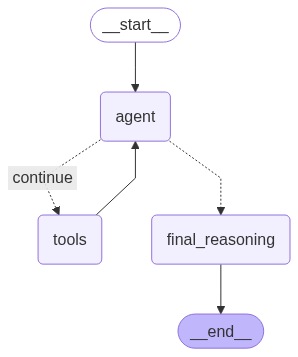

In [102]:
senior_agent = create_senior_subgraph()
display(Image(senior_agent.get_graph().draw_mermaid_png()))

In [103]:
URL = "https://github.com/NVlabs/describe-anything/blob/main/images/1.jpg?raw=true"
Q = "What color is the dog's fur?"

thread = {"configurable": {"thread_id": "1"}}
analyst_result = senior_agent.invoke(
    {
        "question": Q,
        "image": URL,
        "analyst": senior_des 
    },
    thread
)

print(analyst_result)

Processing 1 tool calls
Processing wikipedia calls
Result: Page: Dog coat
Summary: The coat of the domestic dog refers to the hair that covers its body. Dogs demonstrate a wide range of coat colors, patterns, textures, and lengths. 
As with other mammals, a dog's fur has many uses, including thermoregulation and protection from cuts or scratches; furthermore, a dog's coat plays an important role in the showing of purebred dogs. Breed standards often include a detailed description of the nature and attributes of that breed's ideal coat. 
A dog's coat is composed of two layers: a top coat of stiff guard hairs that help repel water and shield from dirt, and an undercoat of soft down hairs, to serve as insulation. Dogs with both under coat and top coat are said to have a double coat. Dogs with a single coat have a coat composed solely of guard hairs, with little or no downy undercoat.
The terms fur and hair are often used interchangeably when describing a dog's coat, however in general, a 

In [104]:
print("Các keys trong state:", analyst_result.keys())
print("Kết quả reasoning:", analyst_result.get("analyst_result", None))
print("Kết quả tổng hợp:", analyst_result.get("results", []))
print("Answer candidate:", analyst_result.get("answer_candidate", None))
print("KBs_Knowledge:", analyst_result.get("KBs_Knowledge", None))


Các keys trong state: dict_keys(['messages', 'question', 'image', 'analyst', 'number_of_steps', 'KBs_Knowledge'])
Kết quả reasoning: None
Kết quả tổng hợp: []
Answer candidate: None
KBs_Knowledge: ["Page: Dog coat\nSummary: The coat of the domestic dog refers to the hair that covers its body. Dogs demonstrate a wide range of coat colors, patterns, textures, and lengths. \nAs with other mammals, a dog's fur has many uses, including thermoregulation and protection from cuts or scratches; furthermore, a dog's coat plays an important role in the showing of purebred dogs. Breed standards often include a detailed description of the nature and attributes of that breed's ideal coat. \nA dog's coat is composed of two layers: a top coat of stiff guard hairs that help repel water and shield from dirt, and an undercoat of soft down hairs, to serve as insulation. Dogs with both under coat and top coat are said to have a double coat. Dogs with a single coat have a coat composed solely of guard hairs

In [105]:
if analyst_result.get("messages"):
    last_message = analyst_result["messages"][-1]
    print("Last message:", getattr(last_message, "content", last_message))

Last message: <think>
Okay, let's tackle this question: "What color is the dog's fur?" 

First, I need to look at the available information provided. There are a few pages related to dogs' coats and liver color. The first page about the dog coat says that dogs have a wide range of coat colors, patterns, textures, and lengths. It mentions that the terms "fur" and "hair" are often used interchangeably, but double coats (like Newfoundland) are called fur coats, while single coats (like Poodles) are hair coats.

Another page on liver color notes that "Liver" refers to a dark brown color in dogs and horses. But the question is about the dog's fur color, not the liver's color. However, there's a mention that Liver describes a dark brown color in the coats of dogs and horses. So maybe the answer relates to the liver color being dark brown, which could be the fur's color.

But wait, the original question is about the color of the dog's fur. The information says that dogs have a wide range of c

## Multi-agent voting

In [106]:
def route_to_analysts(state: ViReAgentState):
    """Router sử dụng Send API để phân phối song song"""
    sends = []
    
    for analyst in state["analysts"]:
        # Tạo state riêng cho mỗi analyst
        analyst_state = {
            "question": state["question"],
            "image": state["image"],
            "analyst": analyst,
            "number_of_steps": 0,
            "messages": []
        }
        
        # Send đến subgraph tương ứng
        if "junior" in analyst.name.lower():
            sends.append(Send("junior_subgraph", analyst_state))
        elif "senior" in analyst.name.lower():
            sends.append(Send("senior_subgraph", analyst_state))
        elif "manager" in analyst.name.lower():
            sends.append(Send("manager_subgraph", analyst_state))
    
    return sends

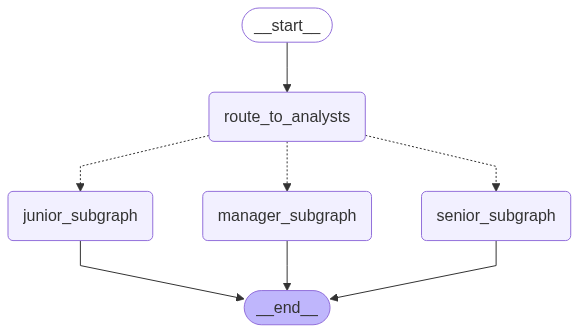

In [107]:
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

main_workflow = StateGraph(ViReAgentState)

# Add nodes
main_workflow.add_node("route_to_analysts", route_to_analysts)
main_workflow.add_node("junior_subgraph", create_junior_subgraph())
main_workflow.add_node("senior_subgraph", create_senior_subgraph())
main_workflow.add_node("manager_subgraph", create_manager_subgraph())
# main_workflow.add_node("aggregate_results", aggregate_results)

# Set entry point
main_workflow.add_edge(START, "route_to_analysts")

# Conditional edges từ router (Send API)
main_workflow.add_conditional_edges(
    "route_to_analysts",
    lambda x: "analysts",  # Dummy function vì Send API tự route
    ["junior_subgraph", "senior_subgraph", "manager_subgraph"]
)

# Tất cả subgraphs đều đi đến aggregation
main_workflow.add_edge("junior_subgraph", END)
main_workflow.add_edge("senior_subgraph", END)
main_workflow.add_edge("manager_subgraph", END)


# Compile
ViReAgent = main_workflow.compile()
display(Image(ViReAgent.get_graph().draw_mermaid_png()))

In [108]:
# agent = analysts["analysts"][1]
# # Create our initial message dictionary
# # "messages": [("user", "How is the weather in Vietnam?")] (optional)
# URL = "https://github.com/NVlabs/describe-anything/blob/main/images/1.jpg?raw=true"
# Q = "What color is the dog's fur?"
# inputs = {"analyst": agent, "question": Q, "image": URL}

# for state in ViReAgent.stream(inputs, stream_mode="values"):
#     if state["messages"]:
#         last_message = state["messages"][-1]
#         last_message.pretty_print()

## Router